The code implements a Quantum Neural Network (QNN) for regression using the JAX library for optimization. It aims to fit a sine function using quantum computing principles via the PennyLane library. Below is a detailed explanation of each part of the code:

# 1. Imports and Dataset Generation

In [29]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import jax
import jax.numpy as jnp
from jax import grad

* PennyLane: A quantum machine learning library that supports hybrid quantum-classical computations.
* NumPy (PennyLane version): Used for numerical operations, compatible with quantum circuits.
Matplotlib: For plotting the results.
* Scikit-learn Metrics: Used to compute mean squared error (MSE) and R-squared (R²) to evaluate the model's performance.
* JAX: A library that provides automatic differentiation and optimization tools, replacing TensorFlow in the original code.

In [30]:
# Generate dataset
num_samples = 100
x = np.linspace(0, 2 * np.pi, num_samples)
y = np.sin(x)

* Dataset Creation: The code generates 100 samples (num_samples) from 0 to 2𝜋, with the target values y being the sine of x.

# 2. Data Normalization and Padding

In [31]:
x_normalized = x / (2 * np.pi)
x_padded = np.vstack([x_normalized, np.cos(x), np.sin(2*x), np.sin(3*x)]).T

* Normalization: x_normalized scales x to the range [0, 1] for more stable quantum circuit operations.
* Padding: x_padded adds more features to x, including cos(x), sin(2*x), and sin(3*x), which introduce higher frequencies. These additional features increase the complexity of the input data, allowing the QNN to capture more intricate patterns.

# 3. Angle Encoding Function

In [32]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))
    gamma0 = np.arcsin(x[0])
    gamma1 = np.arcsin(x[1])
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2, gamma0, gamma1])


* Angle Calculation: This function computes a set of angles for quantum rotation gates based on the input vector x. These angles (beta and gamma) include nonlinear transformations (like arcsin) and are used to encode the input data into quantum states, allowing the QNN to explore a wider range of patterns (frequencies).

# 4. Quantum Device and Circuit Definition

In [33]:
num_qubits = 2
dev = qml.device('default.qubit', wires=num_qubits)

* Quantum Device: The code sets up a quantum device (dev) with 2 qubits using PennyLane's default.qubit simulator.

In [34]:
def angle_encoding(angles):
    qml.RY(angles[0], wires=0)
    qml.RY(angles[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(angles[2], wires=0)
    qml.RY(angles[3], wires=1)
    qml.RX(angles[4], wires=0)
    qml.RX(angles[5], wires=1)


* Angle Encoding Circuit: This function applies quantum gates (RY and RX rotations) to encode the input angles onto the quantum device. The CNOT gate introduces entanglement between the qubits, enhancing the QNN's expressive power.

In [49]:
def layern(weights):
    qml.RY(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(weights[2], wires=0)
    qml.RY(weights[3], wires=1)

def layer(weights):
    qml.Rot(weights[0],weights[1],weights[2], wires=0)
    qml.Rot(weights[3],weights[4],weights[5], wires=1)
    qml.CNOT(wires=[0, 1])

* **Quantum Layer:** This function defines a single layer of the QNN, applying a series of RY rotations and a CNOT gate. The weights control the rotation angles, which are learned during training.

In [50]:
@qml.qnode(dev, interface='jax')
def quantum_neural_network(x, weights, num_layers):
    angles = get_angles(x)
    angle_encoding(angles)
    for i in range(num_layers):
        layer(weights[i])
    return qml.expval(qml.PauliZ(0))


* **QNN Definition:** The quantum neural network is defined as a QNode (quantum node) with PennyLane, interfacing with JAX. The network consists of an angle encoding step followed by several layers of quantum operations. The output is the expectation value of the Pauli-Z operator on the first qubit, which acts as the prediction.

# 5. Cost Function and Optimization

In [53]:
# Initialize weights for each layer
np.random.seed(0)
num_qubits = 2
num_layers = 2  # Specify the number of layers here
weights = np.random.random(size=(num_layers, 6)) 
#weights = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)

In [54]:
quantum_neural_network(x_padded[0], weights, num_layers)

Array(0.01115999, dtype=float32)

* **Weight Initialization:** Random weights are initialized for the QNN layers, with num_layers specifying the depth of the network.

In [55]:
def cost(weights, x, y, num_layers):
    predictions = jnp.array([quantum_neural_network(xi, weights, num_layers) for xi in x])
    return jnp.mean((predictions - y) ** 2)


* **Cost Function:** The cost function calculates the mean squared error (MSE) between the QNN's predictions and the true labels y. This function will be minimized during training.

In [56]:
grad_cost = grad(cost)


* **Gradient Calculation:** JAX's grad function is used to compute the gradient of the cost function with respect to the weights. This is essential for updating the weights during training.

In [57]:
# Training loop
learning_rate = 0.1
steps = 100

for i in range(steps):
    gradients = grad_cost(weights, x_padded, y, num_layers)
    weights = weights - learning_rate * gradients
    
    if (i + 1) % 20 == 0:
        current_cost = cost(weights, x_padded, y, num_layers)
        print(f"Step {i+1}, Cost: {current_cost}")


Step 20, Cost: 0.5602484941482544
Step 40, Cost: 0.5258303880691528
Step 60, Cost: 0.4741488993167877
Step 80, Cost: 0.4151332676410675
Step 100, Cost: 0.35663095116615295


In [58]:
# Training loop
learning_rate = 0.1
steps = 100

for i in range(steps):
    gradients = grad_cost(weights, x_padded, y, num_layers)
    weights = weights - learning_rate * gradients
    
    if (i + 1) % 20 == 0:
        current_cost = cost(weights, x_padded, y, num_layers)
        print(f"Step {i+1}, Cost: {current_cost}")

Step 20, Cost: 0.30577725172042847
Step 40, Cost: 0.27208688855171204
Step 60, Cost: 0.2537524700164795
Step 80, Cost: 0.2433900386095047
Step 100, Cost: 0.23672540485858917


In [62]:
# Training loop
learning_rate = 0.1
steps = 100

for i in range(steps):
    gradients = grad_cost(weights, x_padded, y, num_layers)
    weights = weights - learning_rate * gradients
    
    if (i + 1) % 20 == 0:
        current_cost = cost(weights, x_padded, y, num_layers)
        print(f"Step {i+1}, Cost: {current_cost}")

/Users/neda/anaconda3/lib/python3.11/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Step 20, Cost: 0.2320854365825653
Step 40, Cost: 0.22876201570034027
Step 60, Cost: 0.22634099423885345
Step 80, Cost: 0.22452425956726074
Step 100, Cost: 0.22309909760951996


In [66]:
# Training loop
learning_rate = 0.4
steps = 100

for i in range(steps):
    gradients = grad_cost(weights, x_padded, y, num_layers)
    weights = weights - learning_rate * gradients
    
    if (i + 1) % 20 == 0:
        current_cost = cost(weights, x_padded, y, num_layers)
        print(f"Step {i+1}, Cost: {current_cost}")

/Users/neda/anaconda3/lib/python3.11/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Step 20, Cost: 0.2192266434431076
Step 40, Cost: 0.21671359241008759
Step 60, Cost: 0.21503710746765137
Step 80, Cost: 0.21400180459022522
Step 100, Cost: 0.21342365443706512


* **Training Loop:** The loop runs for 400 steps, updating the weights using gradient descent. The learning_rate controls the step size. Every 20 steps, the current cost is printed to monitor training progress.

# 6. Model Evaluation

In [67]:
predictions = [quantum_neural_network(xi, weights, num_layers) for xi in x_padded]
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")


Mean Squared Error (MSE): 0.21342365824371407
R-squared: 0.5688410944571433


* **Predictions:** The trained QNN is used to make predictions on the training data.
* **Metrics:** The Mean Squared Error (MSE) and R-squared (R²) are computed to evaluate the model's performance.

# 7. Generalization to Unseen Data

In [68]:
num_unseen_samples = 30
x_unseen = np.linspace(0, 2 * np.pi, num_unseen_samples)
y_unseen = np.sin(x_unseen)
x_unseen_normalized = x_unseen / (2 * np.pi)
x_unseen_padded = np.vstack([x_unseen_normalized, np.cos(x_unseen), np.sin(2*x_unseen), np.sin(3*x_unseen)]).T

predictions_unseen = np.array([quantum_neural_network(xi, weights, num_layers) for xi in x_unseen_padded])
mse_unseen = mean_squared_error(y_unseen, predictions_unseen)
r2_unseen = r2_score(y_unseen, predictions_unseen)

print(f"Mean Squared Error (MSE) on unseen data: {mse_unseen}")
print(f"R-squared on unseen data: {r2_unseen}")


/Users/neda/anaconda3/lib/python3.11/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Mean Squared Error (MSE) on unseen data: 0.20777723121036332
R-squared on unseen data: 0.5701160733578691


* **Generalization:** The trained model is tested on unseen data, generated in the same way as the training data but with different sample points. The performance is evaluated using MSE and R² on this new dataset.

# 8. Plotting Results

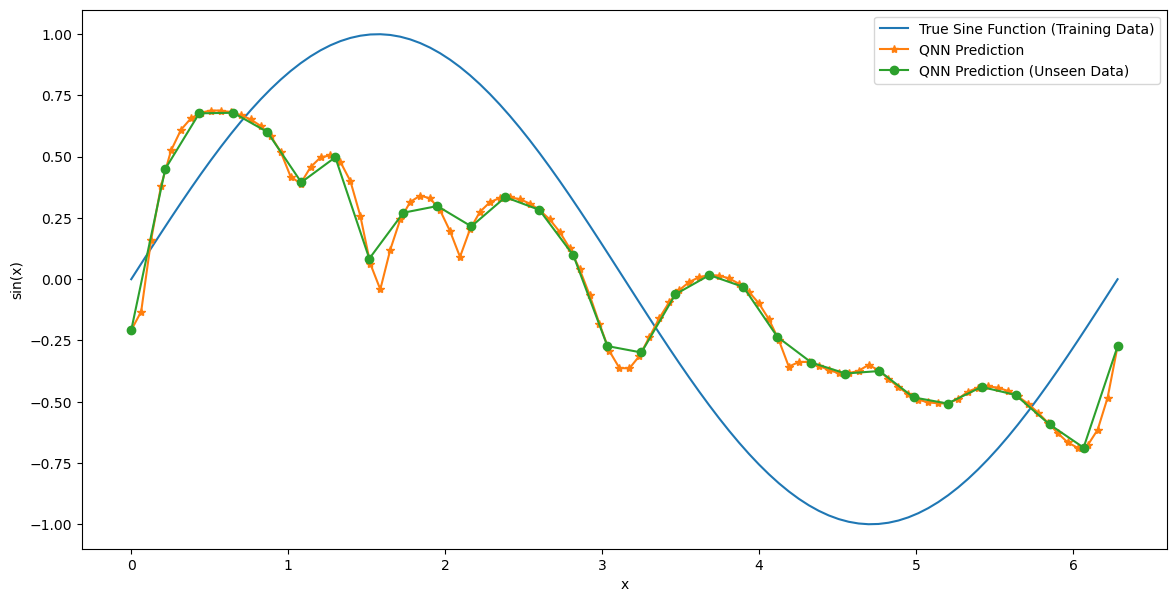

In [69]:
plt.figure(figsize=(14, 7))
plt.plot(x, y, label='True Sine Function (Training Data)')
plt.plot(x, predictions, label='QNN Prediction', marker='*')
plt.plot(x_unseen, predictions_unseen, label='QNN Prediction (Unseen Data)', marker='o')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()